In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn

# Import moving MNIST

In [2]:
Moving_MNIST = np.load('data/mnist_test_seq.npy')
Moving_MNIST.shape

(20, 10000, 64, 64)

# Give `torch` the data

In [3]:
# Making into PyTorch tensor
Moving_MNIST_tensor = torch.from_numpy(Moving_MNIST)

# Putting the existing dimensions into appropriate order
Moving_MNIST_tensor = Moving_MNIST_tensor.permute(1, 0, 2, 3)

# Added the acknowledge that this is 1 spectral band
Moving_MNIST_tensor = Moving_MNIST_tensor.unsqueeze(2)

# Checking shape
Moving_MNIST_tensor.shape

torch.Size([10000, 20, 1, 64, 64])

# Separating $x$ (first $10$ in each sequence) and $y$ (last $10$ in each sequence)

In [4]:
x = Moving_MNIST_tensor[:, :10, :, :, :].float()
x = (x - x.min()) / (x.max() - x.min())

y = Moving_MNIST_tensor[:, 10:, :, :, :].float()
y = (y - y.min()) / (y.max() - y.min())

# Viewing the side-by-side $(x, y)$ sequences

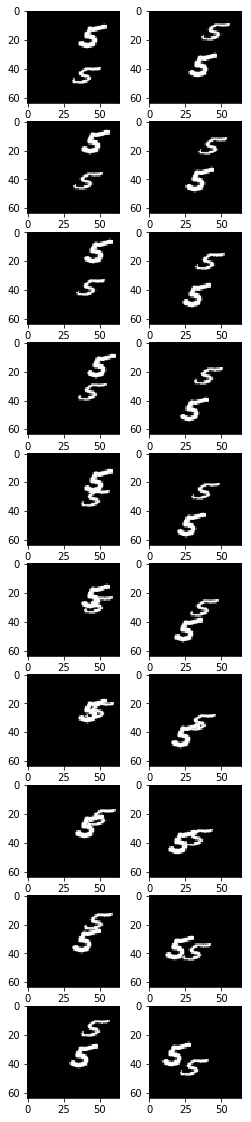

In [5]:
f, axarr = plt.subplots(10,2)
f.set_figheight(20)
f.set_figwidth(4)

random_index = np.random.choice(len(Moving_MNIST_tensor))

for i in range(10):
    x_reduced = x[random_index, i, 0, :, :]
    y_reduced = y[random_index, i, 0, :, :]
    
    axarr[i, 0].imshow(x_reduced, cmap = 'gist_gray')
    axarr[i, 1].imshow(y_reduced, cmap = 'gist_gray')

# Defining the model

In [6]:
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, GPU):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        self.GPU         = GPU
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        to_return = (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)),
                     Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)))
        if self.GPU:
            to_return = (to_return[0].cuda(), to_return[1].cuda())
        return(to_return)


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first, bias, return_all_layers, GPU):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.GPU = GPU

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          GPU=self.GPU))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [7]:
# Picking one of the like-sequence tensors within the list to set parameters
channels = x.shape[2]
height = x.shape[3]
width = x.shape[4]

In [8]:
conv_lstm = ConvLSTM(input_size = (height,
                                   width),
                     input_dim = channels,
                     hidden_dim = [128, 64, 64, 1],
                     kernel_size = (5, 5),
                     num_layers = 4,
                     batch_first = True,
                     bias = True,
                     return_all_layers = False,
                     GPU = True)

In [9]:
conv_lstm.cuda()

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(129, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(65, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

# Training

In [10]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(conv_lstm.parameters(),
                                lr = 10**(-3),
                                alpha = 0.9)

In [11]:
loss_list = []

minibatch_size = 8

for iteration in range(300):
    minibatch_indices = np.random.randint(0,
                                          len(x),
                                          (1, minibatch_size)).tolist()[0]
    
    
    convtime_lstm_output, convtime_lstm_state = conv_lstm(
        x[minibatch_indices,:, :, :, :].cuda()
    )
    
    conv_lstm_pred_target = convtime_lstm_output[0]
    
    current_loss = loss(conv_lstm_pred_target,
                        y[minibatch_indices, :, :, :, :].cuda())
    loss_list.append(current_loss.item())
    
    optimizer.zero_grad()
    current_loss.backward()
    optimizer.step()
    
    if (iteration % 50) == 0:
        print('Iteration: ', iteration, '\n\tCurrent loss: ', current_loss.item())

Iteration:  0 
	Current loss:  0.04172258451581001
Iteration:  50 
	Current loss:  0.037653930485248566
Iteration:  100 
	Current loss:  0.04557434469461441
Iteration:  150 
	Current loss:  0.03681471198797226
Iteration:  200 
	Current loss:  0.04835369810461998
Iteration:  250 
	Current loss:  0.0423511266708374


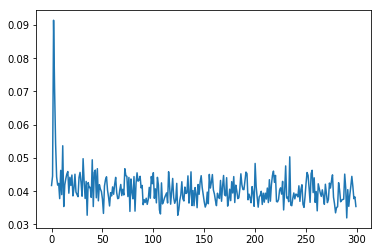

In [12]:
plt.plot(loss_list);

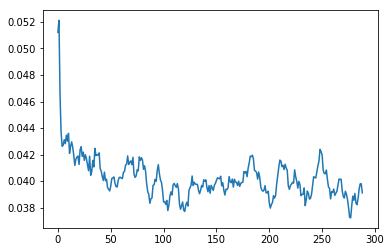

In [13]:
plt.plot(np.convolve(loss_list, 1/10*np.ones(10))[10:-10]);

# Getting random predictions

In [14]:
minibatch_indices = np.random.randint(0,
                                      len(x),
                                      (1, minibatch_size)).tolist()[0]

convtime_lstm_output, convtime_lstm_state = conv_lstm(
    x[minibatch_indices,:, :, :, :].cuda()
)

conv_lstm_pred_target = convtime_lstm_output[0]

# Viewing random predictions

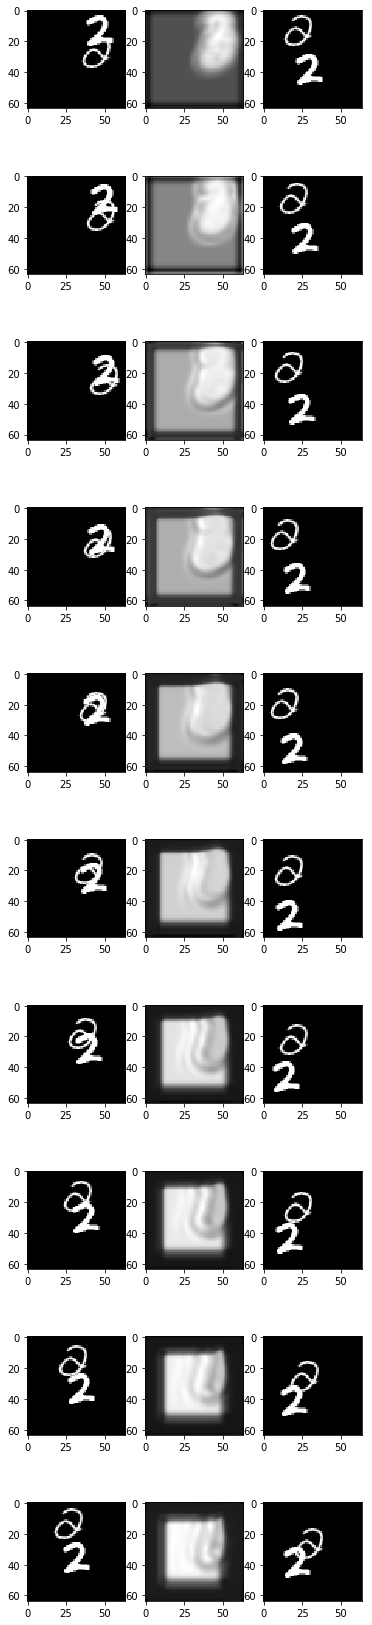

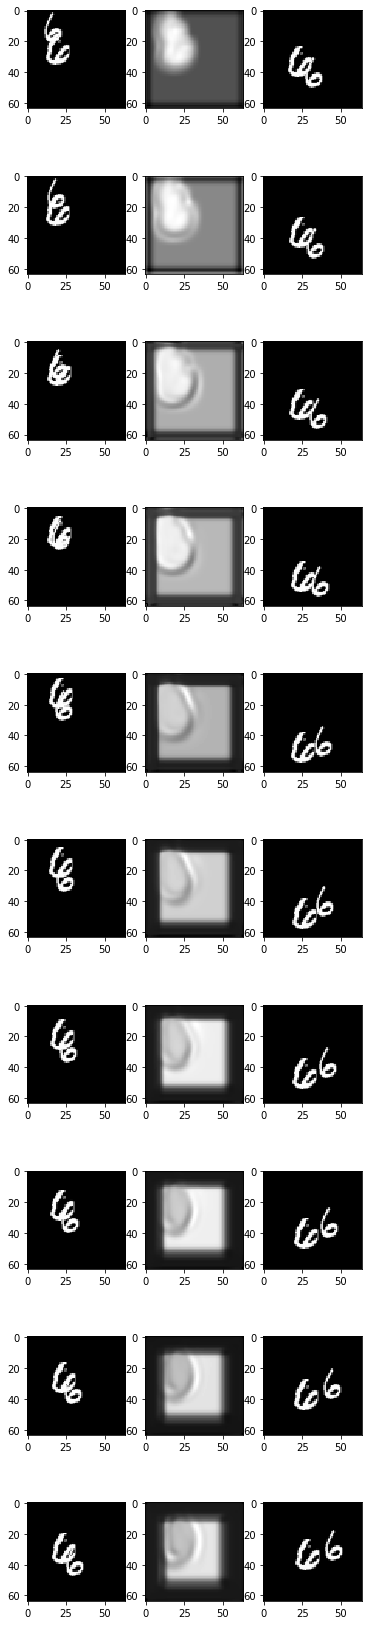

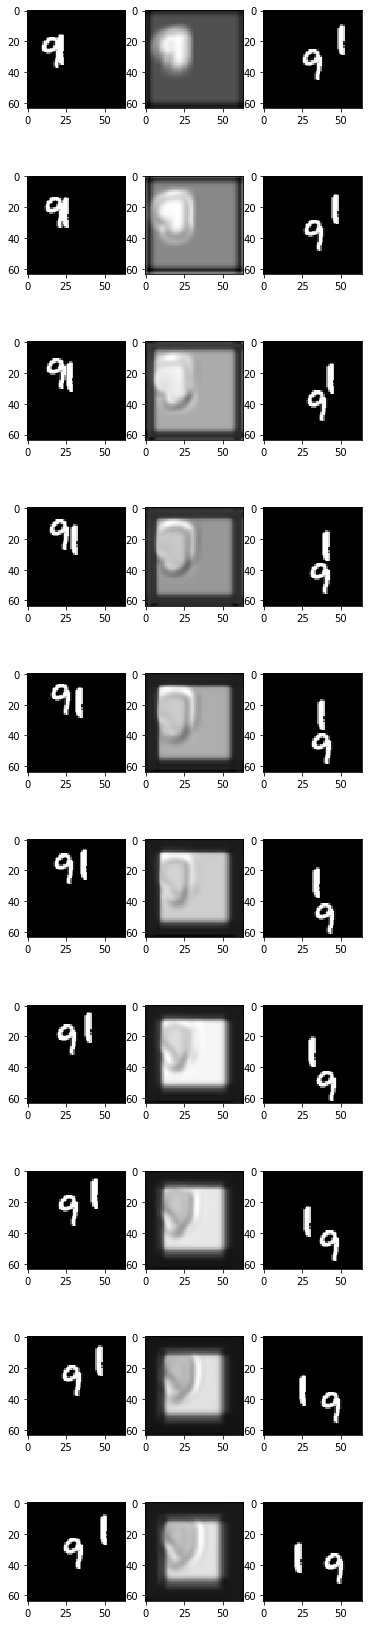

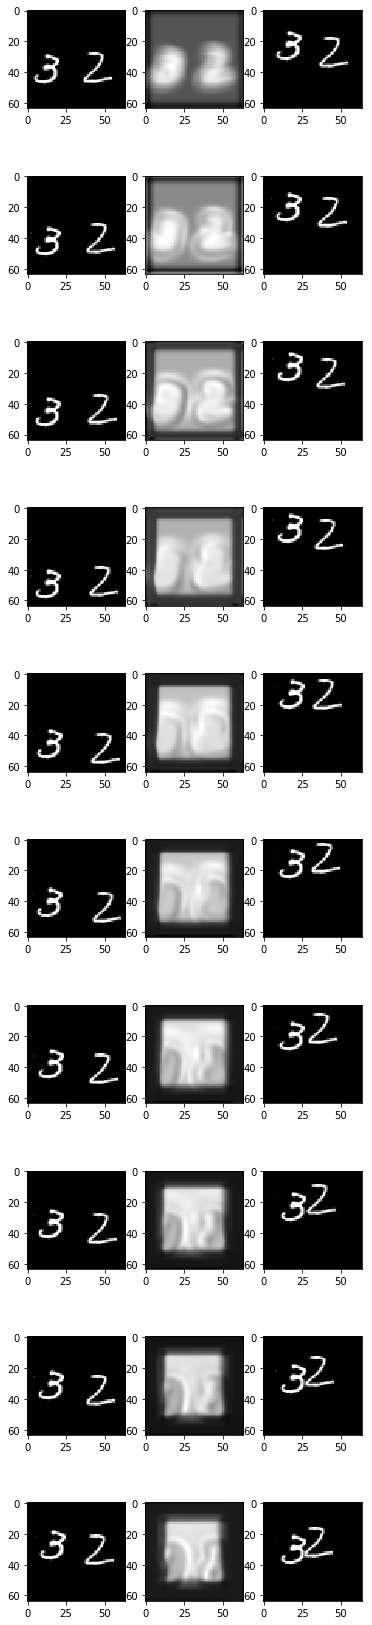

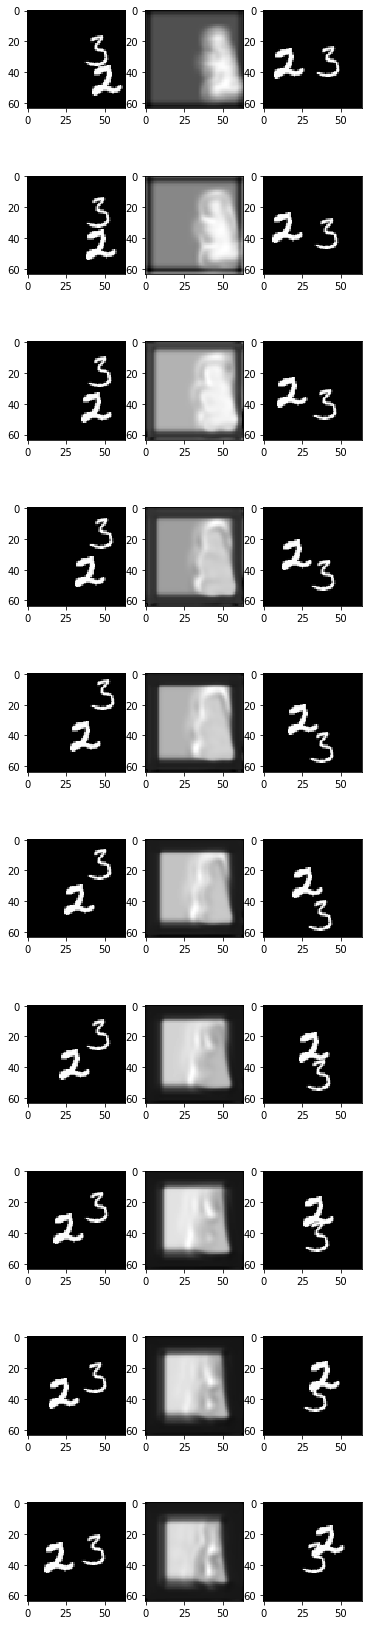

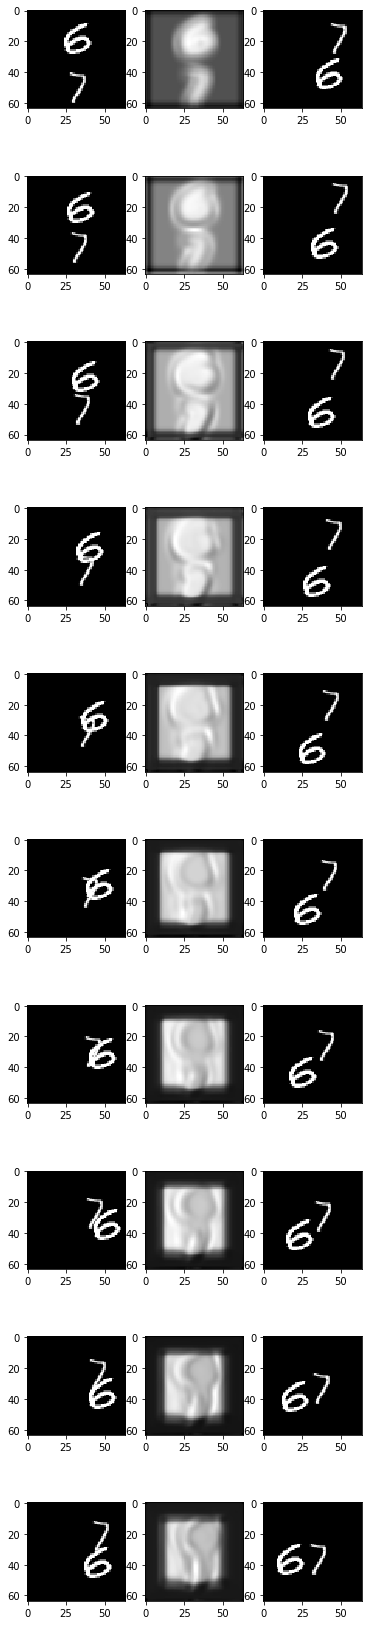

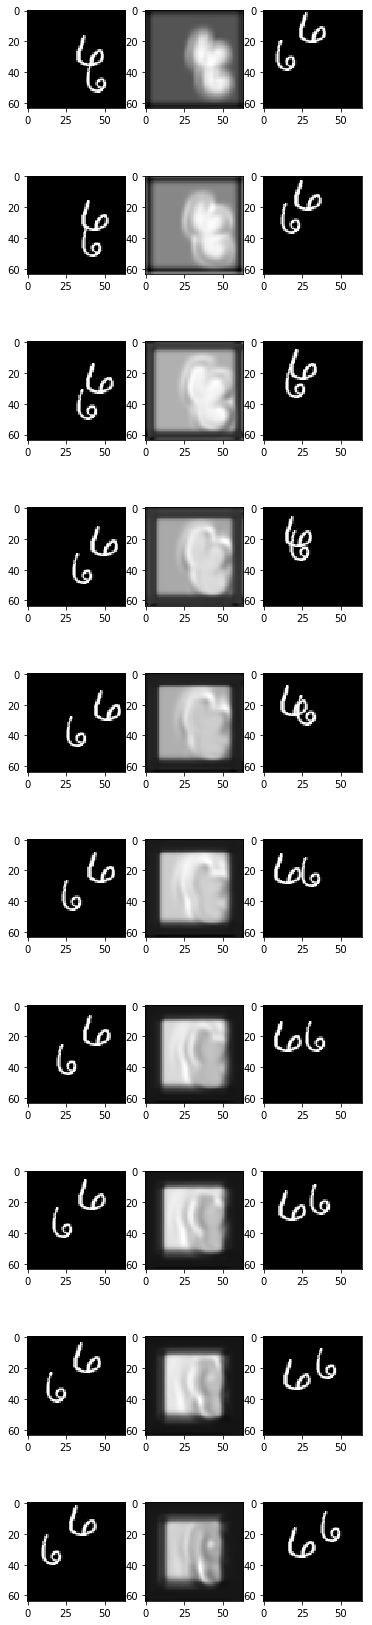

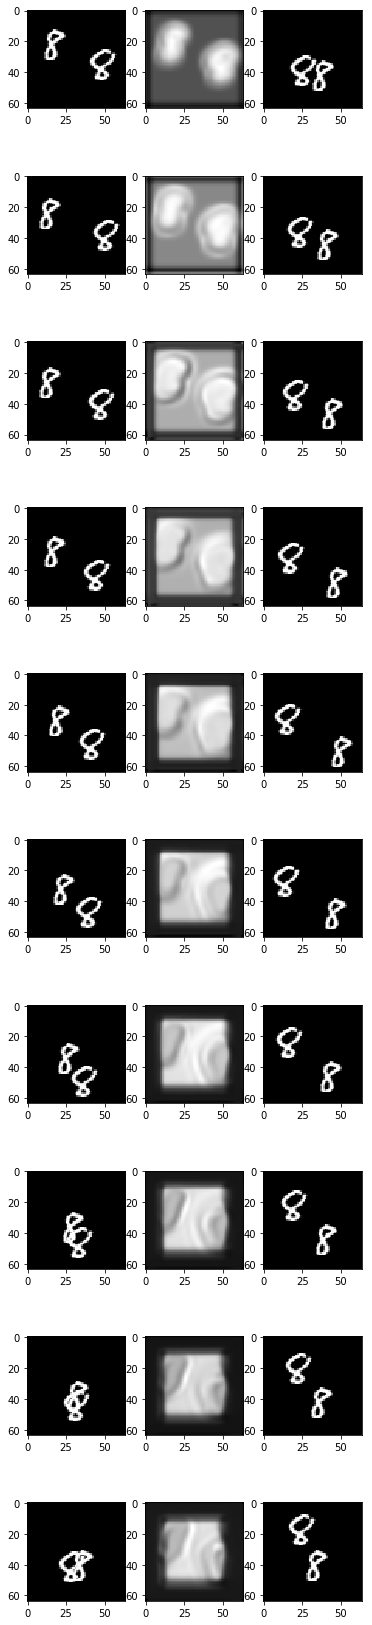

In [15]:
for i in range(minibatch_size):
    num_in_sequences = x.shape[1]
    f, axarr = plt.subplots(num_in_sequences, 3)
    f.set_figheight(num_in_sequences * 3)
    f.set_figwidth(6)
    for j in range(num_in_sequences):
        current_x_image = x[minibatch_indices,:, :, :, :][i, j, 0, :, :].data.numpy()
        axarr[j, 0].imshow(current_x_image, cmap = 'gist_gray')
        current_y_pred  = conv_lstm_pred_target[i, j, 0, :, :].data.cpu().numpy()
        axarr[j, 1].imshow(current_y_pred, cmap = 'gist_gray')
        current_y_image = y[minibatch_indices,:, :, :, :][i, j, 0, :, :].data.cpu().numpy()
        axarr[j, 2].imshow(current_y_image, cmap = 'gist_gray')

-0.012200846 0.11536153
0.0 1.0


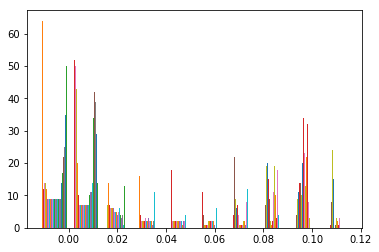

In [16]:
plt.hist(current_y_pred)
print(current_y_pred.min(), current_y_pred.max())
print(current_y_image.min(), current_y_image.max());